## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [8]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt

from alfi.utilities import softplus
from alfi.datasets import P53Data
from alfi.configuration import VariationalConfiguration
from alfi.models import OrdinaryLFM, TrainMode, generate_multioutput_gp
from alfi.plot import Plotter1d, Colours, tight_kwargs
from alfi.trainers import VariationalTrainer, PreEstimator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's start by importing our dataset...

In [2]:
mse = list()

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.7802, 0.6483, 0.6524, 0.6862, 0.7187],
        [2.0000, 1.8724, 1.5252, 1.4483, 1.5671, 1.5900],
        [3.0000, 2.7992, 2.1653, 1.9575, 2.1902, 2.1790],
        [4.0000, 3.1817, 2.2907, 1.9826, 2.2985, 2.2582],
        [5.0000, 3.8881, 2.7719, 2.3834, 2.7637, 2.6986],
        [6.0000, 4.7466, 3.3671, 2.8679, 3.3348, 3.2341],
        [7.0000, 4.7645, 3.1640, 2.5888, 3.1134, 2.9875],
        [8.0000, 4.1319, 2.4563, 1.9007, 2.4076, 2.2871],
        [9.0000, 3.4518, 1.8338, 1.3640, 1.8026, 1.7093]])
torch.Size([1, 5, 10]) torch.Size([1, 1, 10]) torch.Size([10])


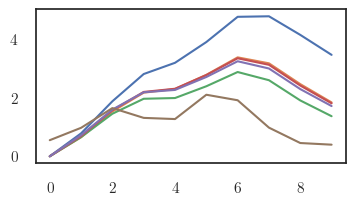

In [56]:
from docs.notebooks.nonlinear.temp_data import Data
from alfi.datasets import ToyTranscriptomics

dataset = ToyTranscriptomics(data_dir='../../../../../data')
i+= 1
data = dataset.train_data[i]
dataset = Data()
print(data[0])
dataset.m_observed = data[0][:, 1:].unsqueeze(0).permute(0, 2, 1)
dataset.data = dataset.m_observed
dataset.t_observed = data[0][:, 0]
dataset.f_observed = softplus(data[1].unsqueeze(0).permute(0, 2, 1))
dataset.data = [(dataset.t_observed, dataset.m_observed[0, i]) for i in range(5)]

print(dataset.m_observed.shape, dataset.f_observed.shape, dataset.t_observed.shape)
class ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        # with torch.no_grad():
        #     sens = torch.tensor(1.)
        #     dec = torch.tensor(0.8)
        #     self.model.raw_sensitivity[3] = self.model.positivity.inverse_transform(sens)
        #     self.model.raw_decay[3] = self.model.positivity.inverse_transform(dec)
        super().after_epoch()

num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset.m_observed[0][i])
plt.plot(dataset.f_observed[0, 0])
t_end = dataset.t_observed[-1]

We use the ordinary differential equation (ODE):

`dy/dt = b + sf(t) - dy`

`f(t) ~ GP(0, k(t, t'))`

Since this is an ODE, we inherit from the `OrdinaryLFM` class.

In [57]:
from torch import softmax
from gpytorch.constraints import Positive
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.raw_decay = Parameter(
            self.positivity.inverse_transform(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_basal = Parameter(
            self.positivity.inverse_transform(0.1 * torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_sensitivity = Parameter(
            self.positivity.inverse_transform(2*torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))

    def nonlinearity(self, f):
        return softplus(f)

    @property
    def decay_rate(self):
        return self.positivity.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.positivity.inverse_transform(value)

    @property
    def basal_rate(self):
        return self.positivity.transform(self.raw_basal)

    @basal_rate.setter
    def basal_rate(self, value):
        self.raw_basal = self.positivity.inverse_transform(value)

    @property
    def sensitivity(self):
        return self.positivity.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.raw_sensitivity = self.decay_constraint.inverse_transform(value)

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        f = self.latent_gp
        if not (self.train_mode == TrainMode.GRADIENT_MATCH):
            f = f[:, :, self.t_index].unsqueeze(2)
            if t > self.last_t:
                self.t_index += 1
            self.last_t = t

        dh = self.basal_rate + self.sensitivity * f - self.decay_rate * h
        return dh

In [67]:
config = VariationalConfiguration(
    # preprocessing_variance=dataset.variance,
    num_samples=80,
    initial_conditions=False
)

num_inducing = 20  # (I x m x 1)
inducing_points = torch.linspace(0, t_end, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, t_end+2, 80, dtype=torch.float32)
step_size = 5e-1
num_training = dataset.m_observed.shape[-1]
use_natural = True
gp_model = generate_multioutput_gp(num_tfs, inducing_points, gp_kwargs=dict(natural=use_natural))

lfm = TranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)
plotter = Plotter1d(lfm, np.arange(5), style='seaborn')
print('hi')

hi


In [68]:
track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.09)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
    pre_variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    pre_parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.005)
    pre_optimizers = [pre_variational_optimizer, pre_parameter_optimizer]

else:
    optimizers = [Adam(lfm.parameters(), lr=0.05)]
    pre_optimizers = [Adam(lfm.parameters(), lr=0.05)]
print(dataset)
trainer = ConstrainedTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)
pre_estimator = PreEstimator(lfm, pre_optimizers, dataset, track_parameters=track_parameters)

interpolating torch.Size([1, 10])


### Outputs prior to training:

Text(0.5, 1.0, 'Latent')

/Users/jacob/miniconda3/envs/gp/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


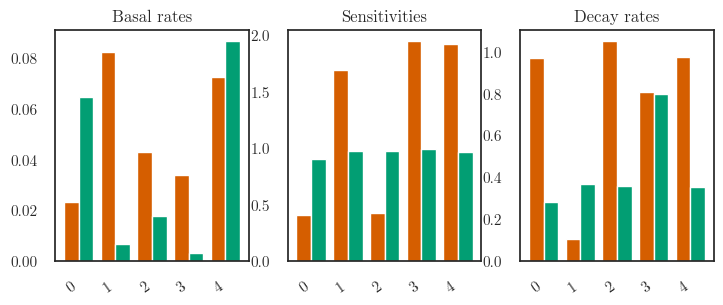

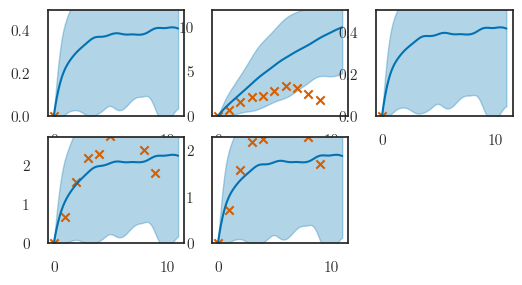

/Users/jacob/miniconda3/envs/gp/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


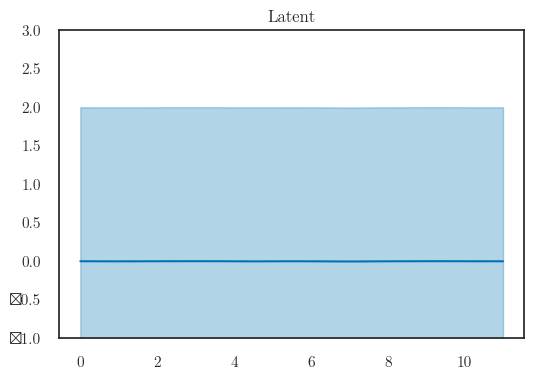

In [69]:
titles = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
kinetics = np.array(kinetics)

plotter.plot_double_bar(kinetics,
                        ground_truths=P53Data.params_ground_truth(),
                        titles=titles)
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')

In [70]:
lfm.set_mode(TrainMode.GRADIENT_MATCH)
# lfm.loss_fn.num_data = 61
# pre_estimator.train(50, report_interval=20);

In [71]:
import time
start = time.time()
lfm.set_mode(TrainMode.NORMAL)
lfm.loss_fn.num_data = num_training
trainer.train(300, report_interval=10, step_size=step_size);
diff = time.time() - start
print(diff)

Epoch 001/300 - Loss: 15.91 0.00kernel: [0.6831972]
Epoch 011/300 - Loss: 11.26 0.23kernel: [0.6519929]
Epoch 021/300 - Loss: 10.17 0.23kernel: [0.6271918]
Epoch 031/300 - Loss: 9.32 0.23kernel: [0.60114497]
Epoch 041/300 - Loss: 8.67 0.24kernel: [0.5778404]
Epoch 051/300 - Loss: 7.93 0.24kernel: [0.5466564]
Epoch 061/300 - Loss: 7.10 0.22kernel: [0.4970551]
Epoch 071/300 - Loss: 6.44 0.22kernel: [0.44300088]
Epoch 081/300 - Loss: 5.96 0.23kernel: [0.399932]
Epoch 091/300 - Loss: 5.66 0.26kernel: [0.36846384]
Epoch 101/300 - Loss: 5.33 0.28kernel: [0.3430239]
Epoch 111/300 - Loss: 5.00 0.30kernel: [0.3193023]
Epoch 121/300 - Loss: 4.69 0.32kernel: [0.29910108]
Epoch 131/300 - Loss: 4.36 0.35kernel: [0.2869468]
Epoch 141/300 - Loss: 3.99 0.39kernel: [0.28508168]
Epoch 151/300 - Loss: 3.69 0.44kernel: [0.28882372]
Epoch 161/300 - Loss: 3.27 0.49kernel: [0.30464602]
Epoch 171/300 - Loss: 2.92 0.56kernel: [0.32060227]
Epoch 181/300 - Loss: 2.54 0.62kernel: [0.34248954]
Epoch 191/300 - Loss

In [72]:
diff

3.272132158279419

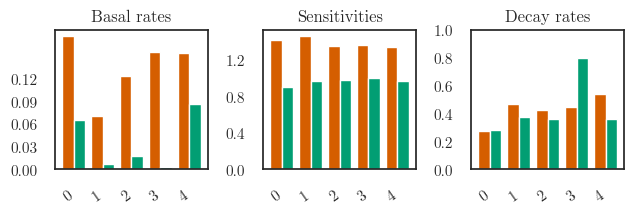

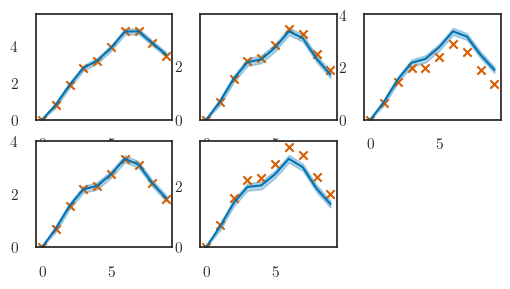

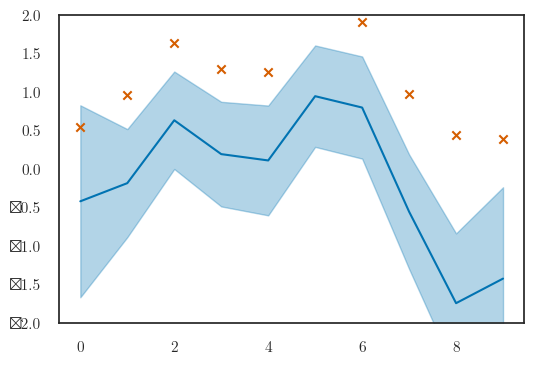

In [73]:
t_predict = torch.linspace(0, t_end, 10, dtype=torch.float32)

# plotter.plot_losses(trainer, last_x=200)
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)


titles = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
kinetics = np.array(kinetics)
plotter.plot_double_bar(kinetics,
                        ground_truths=P53Data.params_ground_truth(),
                        titles=titles,
                        figsize=(6.5, 2.3),
                        yticks=[
                            np.linspace(0, 0.12, 5),
                            np.linspace(0, 1.2, 4),
                            np.arange(0, 1.1, 0.2),
                        ])


plt.tight_layout()
# plt.savefig('./kinetics.pdf', **tight_kwargs)

out_m = plotter.plot_gp(q_m, t_predict,
                t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)
out_f = plotter.plot_gp(q_f, t_predict, t_scatter=dataset.t_observed, y_scatter=dataset.f_observed, ylim=(-2, 2))


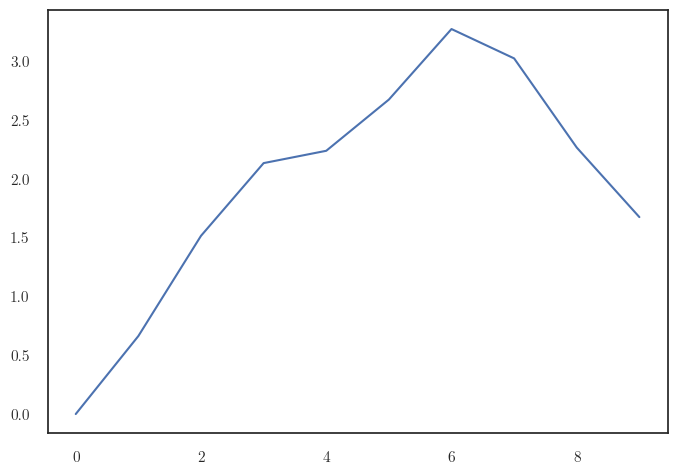

In [74]:
plt.plot(out_m.loc.view(1, 10, 5)[0, :, 1].detach())

In [75]:
print(dataset.f_observed)
m = torch.square(softplus(out_m.loc).view(10, 5).t() - dataset.m_observed[0]).mean()
print(softplus(out_f.loc))
print(m)

tensor([[[0.5479, 0.9692, 1.6403, 1.3070, 1.2672, 2.0945, 1.9069, 0.9747,
          0.4514, 0.3951]]])
tensor([0.5067, 0.6072, 1.0612, 0.7965, 0.7522, 1.2766, 1.1723, 0.4552, 0.1619,
        0.2166])
tensor(0.1170, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [355]:
print(dataset.f_observed)
m = torch.square(softplus(out_f.loc) -  (dataset.f_observed.squeeze())).mean()
print(softplus(out_f.loc))
print(m)

tensor([[[0.5479, 0.9692, 1.6403, 1.3070, 1.2672, 2.0945, 1.9069, 0.9747,
          0.4514, 0.3951]]])
tensor([0.7324, 1.0658, 1.4738, 1.3628, 1.4182, 1.9284, 1.7798, 0.9462, 0.5074,
        0.4947])
tensor(0.0155)


In [343]:
print(torch.square(softplus(out_f.loc) - softplus(dataset.f_observed)))
mse.append(m)
print(mse, np.mean(mse))

tensor([[[1.3362e-05, 1.3245e-01, 4.9012e-01, 2.6299e-01, 2.5166e-01,
          8.1518e-01, 7.1956e-01, 2.6095e-01, 4.0617e-02, 2.9958e-03]]])
[tensor(0.3148), tensor(0.0171), tensor(0.0270), tensor(0.1859), tensor(0.1869), tensor(0.0265), tensor(0.1557), tensor(0.1408), tensor(0.2025), tensor(0.2300), tensor(0.4136), tensor(0.1312), tensor(0.1932), tensor(0.2951), tensor(0.2977)] 0.18785356


In [244]:

print(mse, np.mean(mse))


[tensor(0.3148), tensor(0.0171), tensor(0.0270), tensor(0.1859), tensor(0.1869), tensor(0.0265), tensor(0.1557), tensor(0.1408), tensor(0.2025)] 0.13967842


In [32]:
torch.save(out_f.loc, '/Users/jacob/proj/gskproj/var_out_f.loc.pt')
torch.save(out_f.covariance_matrix, '/Users/jacob/proj/gskproj/var_out_f.covariance.pt')
